# CNN MNIST Digit Recognizer (OpenCL)

In [1]:
import torch
import pytorch_ocl
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import time
import os
from matplotlib import pyplot as plt
from model_ocl.model import SimpleCNN_OCL   # Use the updated model above

In [2]:
d = "ocl:1"
# test if opencl backend is working
a = torch.randn(10, 10, device=d)
print(a)

tensor([[ 1.4412, -1.7645, -0.1140,  0.1863, -1.4518, -0.9216,  0.3237,  1.5785,
         -1.2744, -1.4533],
        [-0.5053,  0.9498,  0.3218,  0.3189,  0.9482, -0.3342,  0.0103, -0.5449,
         -0.3457,  1.0050],
        [-0.4794, -0.2319, -2.4116,  0.4546,  0.0767,  1.2092,  0.2036,  1.3262,
          1.2456,  0.5821],
        [-1.1348, -0.2308, -0.7435, -0.6158,  1.3006, -0.6377,  1.1947,  0.4631,
         -0.8687, -0.0273],
        [ 1.1256, -0.1941,  0.6241,  1.3674, -0.5763, -1.1716, -0.9172, -0.3326,
         -0.6424, -0.6431],
        [-1.1170, -0.1181,  0.1690,  0.0589,  0.9158,  0.0909,  0.1061,  0.9689,
         -1.1531,  0.5850],
        [ 0.5827, -0.2276,  1.6637,  0.0779,  0.0497, -0.5804,  0.9948, -1.1589,
          1.6137, -0.9840],
        [ 0.9786, -0.7556, -0.5454,  0.8974, -0.0475, -0.3511,  2.4212,  0.5486,
         -0.2556,  0.4545],
        [-0.7200,  1.6199, -1.0691, -0.3905, -0.9574,  0.2680, -1.2111, -0.5085,
         -0.3359,  0.0704],
        [ 1.3102, -

In [3]:
# --- Hyperparameters and Setup ---
DEVICE = torch.device(d)   # <-- USE OPENCL GPU
LEARNING_RATE = 0.001
BATCH_SIZE = 512
NUM_EPOCHS = 10
TRAIN_VAL_SPLIT_RATIO = 0.9

In [4]:
# --- 2. Load Data and Define DataLoaders ---
def get_dataloaders():

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    full_train_dataset = datasets.MNIST(
        root="./data",
        train=True,
        transform=transform,
        download=True
    )

    test_dataset = datasets.MNIST(
        root="./data",
        train=False,
        transform=transform,
        download=True
    )

    train_size = int(len(full_train_dataset) * TRAIN_VAL_SPLIT_RATIO)
    val_size = len(full_train_dataset) - train_size

    train_subset, val_subset = random_split(
        full_train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader

In [5]:
print(f"Using device: {DEVICE}")

train_loader, val_loader, test_loader = get_dataloaders()

model = SimpleCNN_OCL().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

Using device: ocl:1


In [6]:
# --- Training Loop ---
print("\n--- Starting Training ---")
total_train_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    model.train()

    running_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_acc = 100 * train_correct / train_total

    # --- Validation ---
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            val_loss = criterion(outputs, labels)

            running_val_loss += val_loss.item()
            _, predicted = torch.max(outputs.data, 1)

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_accuracy = 100 * val_correct / val_total

    train_loss_history.append(avg_train_loss)
    train_acc_history.append(avg_train_acc)
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(avg_val_accuracy)

    epoch_duration_s = time.time() - epoch_start_time

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train: Loss={avg_train_loss:.4f}, Acc={avg_train_acc:.2f}% | "
          f"Val Loss={avg_val_loss:.4f}, Acc={avg_val_accuracy:.2f}% | "
          f"Duration: {epoch_duration_s:.2f}s")

total_train_duration_m = (time.time() - total_train_start_time) / 60.0
print(f"Total Training Time: {total_train_duration_m:.2f} minutes")
print("--- Finished Training ---")


--- Starting Training ---


C:\Users\kevin\AppData\Local\Temp\ipykernel_31120\3913228487.py:25: UserWarning: The operator 'aten::max.dim_max' is not currently supported on the ocl backend. Please open an issue at for requesting support https://github.com/artyom-beilis/pytorch_dlprim/issues (Triggered internally at C:\Users\artik\Projects\build_env\pytorch_dlprim\src\tensor_ops.cpp:417.)
  _, predicted = torch.max(outputs.data, 1)
C:\Users\kevin\AppData\Local\Temp\ipykernel_31120\3913228487.py:47: UserWarning: The operator 'aten::max.dim_max' is not currently supported on the ocl backend. Please open an issue at for requesting support https://github.com/artyom-beilis/pytorch_dlprim/issues (Triggered internally at C:\Users\artik\Projects\build_env\pytorch_dlprim\src\tensor_ops.cpp:417.)
  _, predicted = torch.max(outputs.data, 1)


Epoch [1/10] | Train: Loss=0.4101, Acc=87.49% | Val Loss=0.0929, Acc=97.10% | Duration: 54.27s
Epoch [2/10] | Train: Loss=0.1072, Acc=96.78% | Val Loss=0.0565, Acc=98.33% | Duration: 25.59s
Epoch [3/10] | Train: Loss=0.0797, Acc=97.71% | Val Loss=0.0549, Acc=98.25% | Duration: 25.22s
Epoch [4/10] | Train: Loss=0.0595, Acc=98.21% | Val Loss=0.0475, Acc=98.60% | Duration: 25.79s
Epoch [5/10] | Train: Loss=0.0476, Acc=98.58% | Val Loss=0.0407, Acc=98.88% | Duration: 25.28s
Epoch [6/10] | Train: Loss=0.0432, Acc=98.70% | Val Loss=0.0383, Acc=98.95% | Duration: 25.05s
Epoch [7/10] | Train: Loss=0.0367, Acc=98.88% | Val Loss=0.0324, Acc=98.98% | Duration: 25.16s
Epoch [8/10] | Train: Loss=0.0328, Acc=99.00% | Val Loss=0.0329, Acc=98.97% | Duration: 25.12s
Epoch [9/10] | Train: Loss=0.0285, Acc=99.13% | Val Loss=0.0360, Acc=98.88% | Duration: 25.21s
Epoch [10/10] | Train: Loss=0.0264, Acc=99.17% | Val Loss=0.0320, Acc=99.07% | Duration: 28.08s
Total Training Time: 4.75 minutes
--- Finished Tr

In [7]:
print("\n--- Evaluating on Test Set ---")
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


--- Evaluating on Test Set ---


C:\Users\kevin\AppData\Local\Temp\ipykernel_31120\1881764236.py:15: UserWarning: The operator 'aten::max.dim_max' is not currently supported on the ocl backend. Please open an issue at for requesting support https://github.com/artyom-beilis/pytorch_dlprim/issues (Triggered internally at C:\Users\artik\Projects\build_env\pytorch_dlprim\src\tensor_ops.cpp:417.)
  _, predicted = torch.max(outputs.data, 1)


Final Test Accuracy: 99.26%


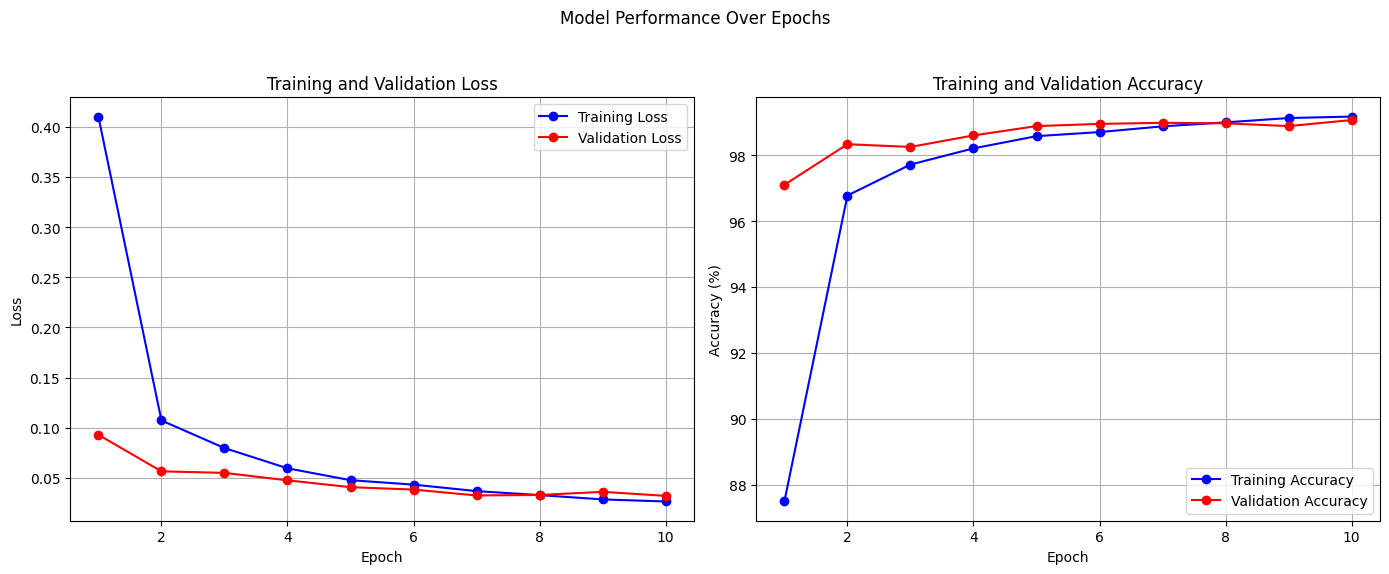

In [8]:
# --- Plotting training and validation metrics ---
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 6))

# Plot 1: Loss vs. Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss_history, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy vs. Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_history, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc_history, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.suptitle('Model Performance Over Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
# --- Save the trained FP32 model ---
print("\n--- Saving FP32 Model ---")

# Define the directory and file path
SAVE_DIR = "model_ocl/bin"
FP32_MODEL_NAME = "CNN-MNIST-OCL-fp32.pt"
FP32_SAVE_PATH = os.path.join(SAVE_DIR, FP32_MODEL_NAME)

# Create the 'bin' directory if it doesn't exist
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model's state dictionary
try:
    torch.save(model.state_dict(), FP32_SAVE_PATH)
    print(f"FP32 Model saved successfully at: {FP32_SAVE_PATH}")
except Exception as e:
    print(f"Error saving FP32 model: {e}")


--- Saving FP32 Model ---
FP32 Model saved successfully at: model_ocl/bin\CNN-MNIST-OCL-fp32.pt


In [10]:
# Helper to evaluate accuracy
def evaluate_model(model, data_loader, device):
    model.eval()
    model.to(device)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return 100 * correct / total

# Helper to measure inference speed
def measure_inference_speed(model, data_loader, device):
    model.eval()
    model.to(device)
    
    # Use one batch for a test run
    dummy_input = next(iter(data_loader))[0].to(device)
    
    # Warm-up runs
    print("  Running warm-up...")
    for _ in range(10):
        _ = model(dummy_input)
        
    # Measure
    print("  Measuring inference time...")
    start_time = time.time()
    num_batches = 0
    with torch.no_grad():
        for images, _ in data_loader:
            _ = model(images.to(device))
            num_batches += 1
            
    end_time = time.time()
    
    total_time = end_time - start_time
    avg_time_per_batch = (total_time / num_batches) * 1000 # in ms
    return avg_time_per_batch

In [11]:
# --- Load the FP32 model ---
print(f"Loading FP32 model from '{FP32_SAVE_PATH}'...")
fp32_model = SimpleCNN_OCL().to(DEVICE)
fp32_model.load_state_dict(
    torch.load(FP32_SAVE_PATH)
)
fp32_model.eval()

fp32_accuracy = evaluate_model(fp32_model, test_loader, DEVICE)
print(f"FP32 Model Accuracy: {fp32_accuracy:.2f}%")

print("Measuring FP32 model...")
fp32_speed_ms = measure_inference_speed(fp32_model, val_loader, DEVICE)
print(f"-> FP32 Avg. Batch Inference Time: {fp32_speed_ms:.2f} ms")

Loading FP32 model from 'model_ocl/bin\CNN-MNIST-OCL-fp32.pt'...


C:\Users\kevin\AppData\Local\Temp\ipykernel_31120\2495308716.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(FP32_SAVE_PATH)
C:\Users\kevin\AppData\Local\Temp

FP32 Model Accuracy: 99.26%
Measuring FP32 model...
  Running warm-up...
  Measuring inference time...
-> FP32 Avg. Batch Inference Time: 187.43 ms
